# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [15]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torchvision
! pip install PyTorch
!pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
  Using cached torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl (19.1 MB)
  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 36, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-b41ui_5c/pytorch_bf12f197a6cc47339cf8dc178176de59/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a proble

In [124]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import sagemaker
from sagemaker.pytorch import PyTorch
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
import torchvision.transforms as transforms

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from PIL import Image
import io
import numpy as np

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

- In this project I will use dog vs cat dataset, where we have 2 classes dogs,and cats

In [2]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-09-27 15:38:53--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  45.8MB/s    in 26s     

2022-09-27 15:39:22 (41.2 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [18]:
"""role = sagemaker.get_execution_role()
bucket = "image-classification-dataset"

os.environ["S3_BUCKET"] = bucket
os.environ['MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['OUTPUT_DATA_DIR'] = 's3://'+bucket+'/output/'
"""

In [6]:
bucket = "image-classification-dataset"
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()


In [10]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges={
    "lr":ContinuousParameter(0.001, 0.01),
    "batch_size":CategoricalParameter([16,32,128]),
    "epochs": IntegerParameter(3,6)
}

objective_metric_name = "test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "test accuracy", "Regex": "Accuracy: ([0-9\\.]+)"}]


In [7]:
os.environ['SM_MODEL_DIR'] = 's3://'+bucket+'/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://'+bucket+'/output/'

In [12]:
#TODO: Create estimators for your HPs
# TODO: Your estimator here

estimator = PyTorch(
    entry_point='hpo.py',
    py_version='py36',
    base_job_name='hpo_tuning',
    role=role,
    framework_version='1.8',
    instance_count=1,
    instance_type='ml.m5.large')

objective_metric_name = "average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "average test accuracy", "Regex": "Testing Loss: ([0-9\\.]+)"}]


In [13]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [8]:
train_data = "s3://{}/{}/".format(bucket, "cats-vs-dogs")
output_directory = "s3://{}/{}/".format(bucket, "output")
model_directory = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= train_data
os.environ['SM_MODEL_DIR']= model_directory
os.environ['SM_OUTPUT_DATA_DIR']= output_directory

In [20]:
# TODO: Fit your HP Tuner
tuner.fit({'train' : train_data},wait=True)
# TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................................................................................................................................................................................!


In [21]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()
#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-10-02 20:19:44 Starting - Preparing the instances for training
2022-10-02 20:19:44 Downloading - Downloading input data
2022-10-02 20:19:44 Training - Training image download completed. Training in progress.
2022-10-02 20:19:44 Uploading - Uploading generated training model
2022-10-02 20:19:44 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test accuracy"',
 'batch_size': '"128"',
 'epochs': '3',
 'lr': '0.002344989724959542',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning-2022-10-02-19-56-37-043"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-531067074017/hpo_tuning-2022-10-02-19-56-37-043/source/sourcedir.tar.gz"'}

In [22]:
hyperparameters = {"batch_size": (best_estimator.hyperparameters()['batch_size']),
                   "lr": best_estimator.hyperparameters()['lr'],
                   "epochs": best_estimator.hyperparameters()['epochs']}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [3]:
hyperparameters = {"batch_size": "128", "epochs":"3", "lr": "0.002344989724959542"}


In [41]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

# Profiler Setup
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1))
# Debugger Setup
debugger_config=DebuggerHookConfig(collection_configs=collection_configs)

In [42]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
) # TODO: Your estimator here
estimator.fit({'train' : train_data},wait=True)

2022-10-04 19:43:02 Starting - Starting the training job...
2022-10-04 19:43:27 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-10-04 19:44:27 Downloading - Downloading input data............
2022-10-04 19:46:28 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-04 19:46:41,267 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-04 19:46:41,271 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-04 19:46:41,295 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-04 19:46:41,305 sagemaker_pytorch_container.training INFO     Invoking user trai

In [43]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
job_name

'pytorch-training-2022-10-04-19-43-01-304'

In [44]:
client

In [45]:
description

{'TrainingJobName': 'pytorch-training-2022-10-04-19-43-01-304',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:531067074017:training-job/pytorch-training-2022-10-04-19-43-01-304',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '"128"',
  'epochs': '"3"',
  'lr': '"0.002344989724959542"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2022-10-04-19-43-01-304"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8-cpu-py36',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetrics

In [46]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial

[2022-10-04 20:10:32.446 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/debug-output


<smdebug.trials.s3_trial.S3Trial object at 0x7f7737efb1d0>:(
    name=debug-output,
    path=s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/debug-output/,
    steps=[0, 10, 20, 24, 25, 26, 27, 28, 29, 30, 31, 38, 48, 56, 57, 58, 59, 60, 61, 62, 63, 66, 76, 86, 88, 89, 90, 91, 92, 93, 94, 95],
    collections=['default', 'weights', 'losses', 'biases', 'all', 'gradients', 'CrossEntropyLoss_output_0', 'relu_input'],
    tensor_names=['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0'],
)

In [47]:
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [48]:
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

8
24


In [49]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [50]:
# TODO: Plot a debugging output.
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps train")
    par.set_xlabel("Steps eval")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Fully TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Fully EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

Fully TRAIN plot
Fully EVAL plot


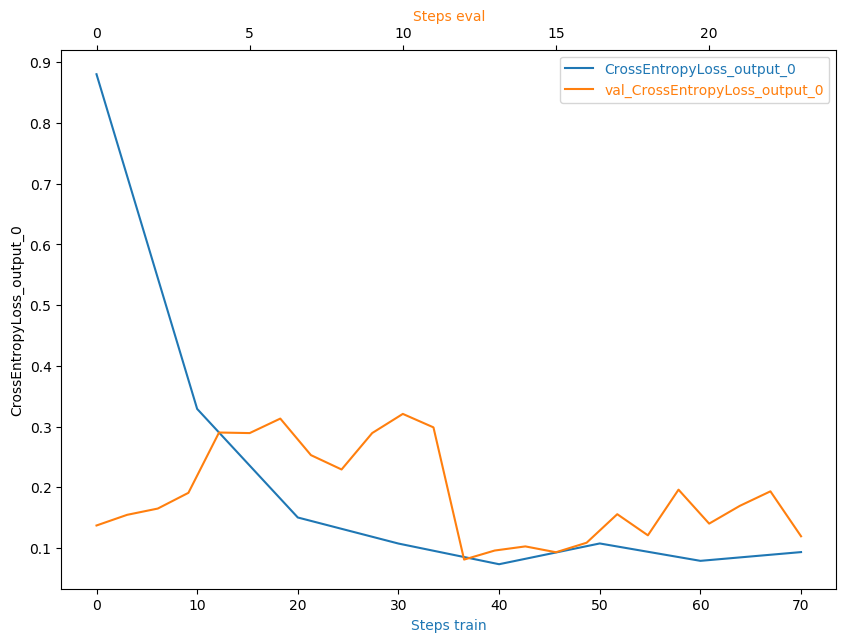

In [51]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [54]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/rule-output


In [65]:
! aws s3 ls {rule_output_path} --recursive

2022-10-04 20:10:00     365543 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-04 20:09:59     212611 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-04 20:09:55        192 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-04 20:09:55        200 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-04 20:09:55       2251 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-04 20:09:55        127 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-04 20:09:55        199 pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-re

In [ ]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-531067074017/pytorch-training-2022-10-04-19-43-01-304/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-531067074017/pytorch-

In [57]:
# TODO: Display the profiler output
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [67]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [130]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

model_data_artifacts = estimator.model_data

model = PyTorchModel(
    entry_point="inference.py",
    role=role,
    model_data=model_data_artifacts,
    framework_version="1.8",
    py_version="py3",
)
predictor=model.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

-------------!

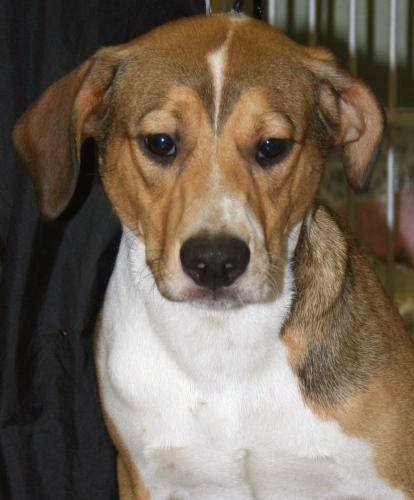

In [116]:
with open("dog.4555.jpg", "rb") as f: 
    image = f.read()
Image.open(io.BytesIO(image))

In [133]:
image = Image.open("dog.4555.jpg")# TODO: Your code to load and preprocess image to send to endpoint for prediction
image_np = (np.array(image))
print(image_np.shape)

img_size = 224
preprocess = transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.ToTensor()
])

input_tensor = preprocess(image)
print(input_tensor.size())
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print(input_batch.size())
image_np = np.array(input_batch)
print(image_np.shape)

dic={0:'cat', 1:'dog'}

response = dic[np.argmax(predictor.predict(image_np))]

(500, 414, 3)
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
(1, 3, 224, 224)


In [134]:
response

'dog'

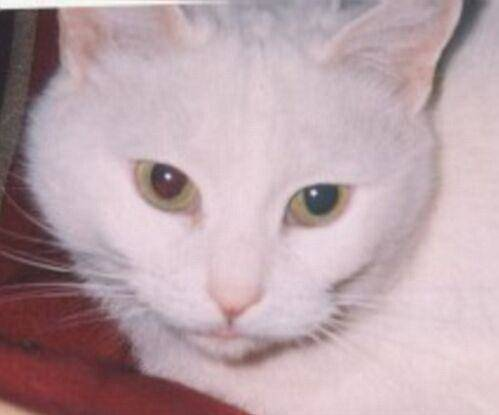

In [135]:
with open("cat.4529.jpg", "rb") as f: 
    image = f.read()
Image.open(io.BytesIO(image))

In [136]:
image = Image.open("cat.4529.jpg")# TODO: Your code to load and preprocess image to send to endpoint for prediction
image_np = (np.array(image))
print(image_np.shape)

img_size = 224
preprocess = transforms.Compose([
        transforms.RandomResizedCrop((224,224)),
        transforms.ToTensor()
])

input_tensor = preprocess(image)
print(input_tensor.size())
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print(input_batch.size())
image_np = np.array(input_batch)
print(image_np.shape)

dic={0:'cat', 1:'dog'}

response = dic[np.argmax(predictor.predict(image_np))]

(415, 499, 3)
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
(1, 3, 224, 224)


In [137]:
response

'cat'

In [138]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()